# Generate initial designs for training data for ART

First import ART package:

In [1]:
import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


All genes we might consider in relation to isopentenol production:

In [2]:
reactions = ['ACCOAC', 
             'MDH',
             'PTAr', 
             'CS', 
             'ACACT1r', 
             'PPC', 
             'PPCK', # zero flux
             'PFL', # zero flux, can be forced
             'PYK', # zero flux 
             'POX'] # zero flux

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

Assing numerical categories to each of the modifications:

In [3]:
modif_dict = {'KO': int(0), 
              'NoMod': int(1),
              'UP': int(2)}

As current version of ART deals only with continuous variables, we will first find recommended designs from interval [0, 1] and then transform each of those to one of defined categories {0, 1, 2} using the function

$$f(x) = 3\lfloor x \rfloor$$

How many reactions you want to consider?

In [5]:
n_reactions = int(input())


 8


How many instances you want to generate?

In [6]:
n_instances = int(input())

 96


In [7]:
n_modifications = len(modif_dict)
reactions = reactions[:n_reactions]
tot_number_mod = n_modifications**n_reactions
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 96 (1.46%)


Next define a dictionary that contains the settings that ART will use to find the recommended designs:

In [8]:
art_params = {}
art_params['input_var'] = reactions
art_params['num_recommendations'] = n_instances - 1
art_params['initial_cycle'] = True
art_params['seed'] = 10
art_params['output_directory'] = './art_files'


Generate recommendations by running ART:

In [9]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
90,0.834820,0.310928,0.017741,0.686528,0.038425,0.702041,0.909326,0.314650
91,0.253443,0.144406,0.797025,0.866835,0.196778,0.915534,0.227534,0.997582
92,0.448214,0.982897,0.229292,0.020562,0.236674,0.920214,0.671678,0.159832
93,0.058396,0.672483,0.191037,0.602885,0.087692,0.708920,0.656125,0.545103
94,0.012306,0.396266,0.981174,0.236980,0.613428,0.391463,0.127033,0.926296


Transform the values for designs back to categories (0, 1 or 2):

In [10]:
df = np.floor(3 * df)
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
90,2.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
91,0.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0
92,1.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0
93,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0
94,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0


Define wild type strain with no modifications:

In [11]:
df.loc[n_instances-1] = [modif_dict['NoMod'] for i in range(n_reactions)] 
df = df.astype(int)
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,0,0,2,2,0,2,0,2
92,1,2,0,0,0,2,2,0
93,0,2,0,1,0,2,1,1
94,0,1,2,0,1,1,0,2
95,1,1,1,1,1,1,1,1


Create Line Names:

In [12]:
df.insert(loc=0, column='Line Name', value=[str(i) for i in range(1,n_instances)]+['WT'])
df.tail()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,92,0,0,2,2,0,2,0,2
92,93,1,2,0,0,0,2,2,0
93,94,0,2,0,1,0,2,1,1
94,95,0,1,2,0,1,1,0,2
95,WT,1,1,1,1,1,1,1,1


How many modifications 'introduced' into each strain?

In [13]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [14]:
df['# Modifs'] = num_of_modifications(df)
df.tail()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,# Modifs
91,92,0,0,2,2,0,2,0,2,8.0
92,93,1,2,0,0,0,2,2,0,7.0
93,94,0,2,0,1,0,2,1,1,5.0
94,95,0,1,2,0,1,1,0,2,5.0
95,WT,1,1,1,1,1,1,1,1,0.0


Find distribution of modifications per gene in the training data set:

In [15]:
df.loc[n_instances] = ['Summary'] + [[list(df[reaction]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for reaction in reactions] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name                                              Summary
ACCOAC          [32.29166666666667, 34.375, 33.33333333333333]
MDH          [33.33333333333333, 33.33333333333333, 33.3333...
PTAr         [33.33333333333333, 33.33333333333333, 33.3333...
CS              [33.33333333333333, 34.375, 32.29166666666667]
ACACT1r      [32.29166666666667, 35.41666666666667, 32.2916...
PPC             [33.33333333333333, 34.375, 32.29166666666667]
PPCK            [32.29166666666667, 34.375, 33.33333333333333]
PFL          [33.33333333333333, 33.33333333333333, 33.3333...
# Modifs                                               5.27083
Name: 96, dtype: object

In [16]:
def plot_distribution(dataframe): 
    bar_height = 1
    labels = ['KO', 'NoMod', 'UP']
    colors = ['#019600', 'grey', '#219AD8']

    data = [ [dataframe[dataframe['Line Name']=='Summary'][r].values[0][num] for r in reactions] 
            for num in range(n_modifications)]
    y_pos = np.arange(len(reactions))

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    patch_handles = []
    # left alignment of data starts at zero
    left = np.zeros(len(reactions)) 
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
                                     color=colors[i%len(colors)], edgecolor='white',
                                     height=bar_height, align='center', 
                                     left=left, label=labels[i]))
        left += d

    # search all of the bar segments and annotate
    for j in range(n_modifications):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

    ax.set_title('Distribution of modifications')
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                    labelbottom='off')
    plt.yticks(y_pos, reactions)
    ax.invert_yaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


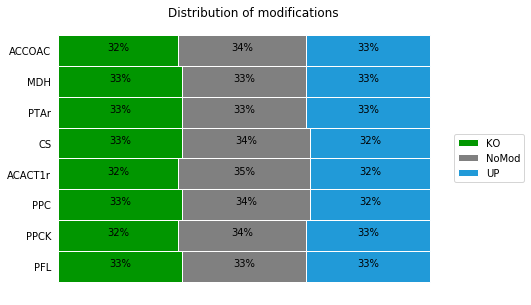

In [17]:
plot_distribution(df)

Save training set:

In [18]:
data_filename = f'./data/training_data_{n_reactions}reactions.csv'
df.loc[0:(n_instances-1)].to_csv(data_filename, 
                                 columns = ['Line Name'] + reactions, 
                                 header = True, index = False)

## Generate isoprenol data

...

## Train ART

In [19]:
data_file = './data/training_data_8reactions_iso.csv'

In [20]:
df = pd.read_csv(data_file)

In [21]:
df.head()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol [mM]
0,1,1,1,2,0,2,0,0,0,0.000000
1,2,1,2,2,2,2,1,1,0,0.208611
2,3,1,0,0,2,1,1,2,0,0.309396
3,4,1,1,1,1,2,2,1,0,0.715185
4,5,2,0,2,1,1,0,1,1,0.118605


In [22]:
df[df['Line Name']=='WT']['Isoprenol [mM]']

95    0.552325
Name: Isoprenol [mM], dtype: float64

Text(0.5,0,'strains')

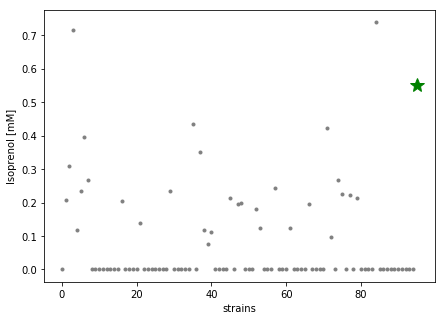

In [23]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(df['Isoprenol [mM]'],'.',color='grey')
ax.plot(95,df[df['Line Name']=='WT']['Isoprenol [mM]'],'g*',markersize=15)
ax.set_ylabel('Isoprenol [mM]')
ax.set_xlabel('strains')

One hot encode variables

In [83]:
df_oneh = pd.get_dummies(data=df, columns=reactions)
df_oneh.head()

,Line Name,Isoprenol [mM],ACCOAC_0,ACCOAC_1,ACCOAC_2,MDH_0,MDH_1,MDH_2,PTAr_0,PTAr_1,...,ACACT1r_2,PPC_0,PPC_1,PPC_2,PPCK_0,PPCK_1,PPCK_2,PFL_0,PFL_1,PFL_2
0,1,0.000000,0,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,0
1,2,0.208611,0,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
2,3,0.309396,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
3,4,0.715185,0,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,1,0,0
4,5,0.118605,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


Store colnames as parameter setting for ART

In [84]:
colnames = df_oneh.columns[2:].tolist()

Pivot dataframe and change column names

In [88]:
df_oneh = df_oneh.set_index('Line Name').stack().reset_index()
df_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
df_oneh.head()

,Line Name,Measurement Type,Value
0,1,Isoprenol [mM],0.0
1,1,ACCOAC_0,0.0
2,1,ACCOAC_1,1.0
3,1,ACCOAC_2,0.0
4,1,MDH_0,0.0


### Running ART

Assign ART parameters:

In [12]:
art_params = {}
art_params['response_var'] = ['Isoprenol [mM]']
art_params['input_var'] = colnames
art_params['seed'] = 10  
art_params['num_recommendations'] = 96   
art_params['cross_val'] = False
art_params['recommend'] = False
art_params['output_directory'] = './results_onehot/'

Run ART with seed (takes around 3h) or load previously run model.

In [13]:
run_art = True

In [14]:
%%time
if run_art:
    art = RecommendationEngine(df_oneh, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

Input Variables                                                    \
                 ACCOAC_0 ACCOAC_1 ACCOAC_2 MDH_0 MDH_1 MDH_2 PTAr_0 PTAr_1   
Line Name                                                                     
1                     0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
10                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    0.0   
11                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
12                    0.0      1.0      0.0   0.0   0.0   1.0    0.0    1.0   
13                    0.0      1.0      0.0   0.0   0.0   1.0    0.0    1.0   
14                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
15                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
16                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
17                    0.0      0.0      1.0   0.0   0.0   1.0    1.0    0.0   
18                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
19                    0.0      0.0      1.0   1.0   0.0   0.0    0.0    1.0   
2                     0.0      1.0      0.0   0.0   0.0   1.0    0.0    0.0   
20                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    1.0   
21                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
22                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
23                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
24                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
25                    1.0      0.0      0.0   1.0   0.0   0.0    0.0    0.0   
26                    0.0      1.0      0.0   0.0   0.0   1.0    1.0    0.0   
27                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    1.0   
28                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
29                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
3                     0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
30                    0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
31                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
32                    0.0      0.0      1.0   0.0   0.0   1.0    1.0    0.0   
33                    0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
34                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
35                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    0.0   
36                    0.0      0.0      1.0   1.0   0.0   0.0    0.0    1.0   
...                   ...      ...      ...   ...   ...   ...    ...    ...   
7                     0.0      0.0      1.0   0.0   1.0   0.0    0.0    0.0   
70                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
71                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
72                    0.0      1.0      0.0   1.0   0.0   0.0    0.0    0.0   
73                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    0.0   
74                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
75                    0.0      0.0      1.0   0.0   1.0   0.0    0.0    0.0   
76                    0.0      1.0      0.0   1.0   0.0   0.0    0.0    0.0   
77                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
78                    0.0      0.0      1.0   0.0   1.0   0.0    1.0    0.0   
79                    0.0      0.0      1.0   0.0   1.0   0.0    1.0    0.0   
8                     0.0      1.0      0.0   0.0   1.0   0.0    1.0    0.0   
80                    0.0      1.0      0.0   0.0   1.0   0.0    1.0    0.0   
81                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
82                    0.0      1.0      0.0   0.0   0.0   1.0    1.0    0.0   
83                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
84                    0.0      0.0      1.0   0.0   1.0   0.

Input Variables                                                    \
                 ACCOAC_0 ACCOAC_1 ACCOAC_2 MDH_0 MDH_1 MDH_2 PTAr_0 PTAr_1   
Line Name                                                                     
1                     0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
10                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    0.0   
11                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
12                    0.0      1.0      0.0   0.0   0.0   1.0    0.0    1.0   
13                    0.0      1.0      0.0   0.0   0.0   1.0    0.0    1.0   
14                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
15                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
16                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    0.0   
17                    0.0      0.0      1.0   0.0   0.0   1.0    1.0    0.0   
18                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
19                    0.0      0.0      1.0   1.0   0.0   0.0    0.0    1.0   
2                     0.0      1.0      0.0   0.0   0.0   1.0    0.0    0.0   
20                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    1.0   
21                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
22                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    1.0   
23                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
24                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
25                    1.0      0.0      0.0   1.0   0.0   0.0    0.0    0.0   
26                    0.0      1.0      0.0   0.0   0.0   1.0    1.0    0.0   
27                    0.0      1.0      0.0   0.0   1.0   0.0    0.0    1.0   
28                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
29                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
3                     0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
30                    0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
31                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
32                    0.0      0.0      1.0   0.0   0.0   1.0    1.0    0.0   
33                    0.0      1.0      0.0   1.0   0.0   0.0    1.0    0.0   
34                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
35                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    0.0   
36                    0.0      0.0      1.0   1.0   0.0   0.0    0.0    1.0   
...                   ...      ...      ...   ...   ...   ...    ...    ...   
7                     0.0      0.0      1.0   0.0   1.0   0.0    0.0    0.0   
70                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
71                    1.0      0.0      0.0   0.0   1.0   0.0    0.0    0.0   
72                    0.0      1.0      0.0   1.0   0.0   0.0    0.0    0.0   
73                    0.0      0.0      1.0   0.0   0.0   1.0    0.0    0.0   
74                    1.0      0.0      0.0   0.0   0.0   1.0    0.0    1.0   
75                    0.0      0.0      1.0   0.0   1.0   0.0    0.0    0.0   
76                    0.0      1.0      0.0   1.0   0.0   0.0    0.0    0.0   
77                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
78                    0.0      0.0      1.0   0.0   1.0   0.0    1.0    0.0   
79                    0.0      0.0      1.0   0.0   1.0   0.0    1.0    0.0   
8                     0.0      1.0      0.0   0.0   1.0   0.0    1.0    0.0   
80                    0.0      1.0      0.0   0.0   1.0   0.0    1.0    0.0   
81                    1.0      0.0      0.0   0.0   0.0   1.0    1.0    0.0   
82                    0.0      1.0      0.0   0.0   0.0   1.0    1.0    0.0   
83                    1.0      0.0      0.0   1.0   0.0   0.0    1.0    0.0   
84                    0.0      0.0      1.0   0.0   1.0   0.

Optimization Progress:   9%|▉         | 37/420 [00:06<01:38,  3.91pipeline/s]

Generation 1 - Current best internal CV score: 0.009935701687498234


Optimization Progress:  12%|█▏        | 52/420 [00:10<01:22,  4.48pipeline/s]

Generation 2 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  16%|█▌        | 68/420 [00:19<01:49,  3.21pipeline/s]

Generation 3 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  20%|██        | 86/420 [00:32<04:40,  1.19pipeline/s]

Generation 4 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  25%|██▍       | 103/420 [00:41<03:43,  1.42pipeline/s]

Generation 5 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  29%|██▉       | 121/420 [00:51<02:24,  2.07pipeline/s]

Generation 6 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  33%|███▎      | 139/420 [00:54<00:56,  4.95pipeline/s]

Generation 7 - Current best internal CV score: 0.0047210104943871505


Optimization Progress:  37%|███▋      | 154/420 [01:00<01:20,  3.30pipeline/s]

Generation 8 - Current best internal CV score: 0.0036396700121253656


Optimization Progress:  41%|████      | 171/420 [01:05<01:11,  3.49pipeline/s]

Generation 9 - Current best internal CV score: 0.0036396700121253656


Optimization Progress:  45%|████▌     | 190/420 [01:11<00:46,  4.96pipeline/s]

Generation 10 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  50%|████▉     | 209/420 [01:15<01:15,  2.78pipeline/s]

Generation 11 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  55%|█████▍    | 229/420 [01:20<00:32,  5.84pipeline/s]

Generation 12 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  59%|█████▉    | 249/420 [01:24<00:36,  4.67pipeline/s]

Generation 13 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  64%|██████▍   | 269/420 [01:32<01:04,  2.35pipeline/s]

Generation 14 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  69%|██████▉   | 289/420 [01:39<00:43,  3.04pipeline/s]

Generation 15 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  74%|███████▎  | 309/420 [02:01<01:21,  1.36pipeline/s]

Generation 16 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  78%|███████▊  | 327/420 [02:26<01:17,  1.20pipeline/s]

Generation 17 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  82%|████████▏ | 344/420 [03:06<02:46,  2.19s/pipeline]

Generation 18 - Current best internal CV score: 0.003622855420172004


Optimization Progress:  86%|████████▌ | 362/420 [03:24<01:02,  1.08s/pipeline]

Generation 19 - Current best internal CV score: 0.0031276347002287506


Generation 20 - Current best internal CV score: 0.0031276347002287506

Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, ElasticNetCV__l1_ratio=0.8, ElasticNetCV__tol=1e-05), ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.9000000000000001, ExtraTreesRegressor__min_samples_leaf=DEFAULT, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=DEFAULT)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:31<00:00, 701.48draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.115714,inf,0.107562,2.495918e-02,-0.060212
Random Forest Regressor,0.014059,NaN,0.034106,1.360862e-03,0.942194
TPOT Regressor,0.003689,NaN,0.008982,9.429017e-05,0.995995
Support Vector Regressor,0.071099,inf,0.032227,6.093651e-03,0.741155
Kernel Ridge Regressor,0.028345,inf,0.041088,2.491636e-03,0.894161
K-NN Regressor,0.071458,NaN,0.089524,1.312067e-02,0.442662
Gaussian Process Regressor,0.000057,inf,0.000066,7.662031e-09,1.000000
Gradient Boosting Regressor,0.015934,inf,0.017346,5.548036e-04,0.976433
Ensemble Model,0.006515,inf,0.011087,1.653604e-04,0.992976


CPU times: user 3min 36s, sys: 5.17 s, total: 3min 41s
Wall time: 6min 4s


In [ ]:
# art.evaluate_models_cv()

In [ ]:
# plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=False, xlim=[[0, 300]], ylim=[[0, 300]], log=False)

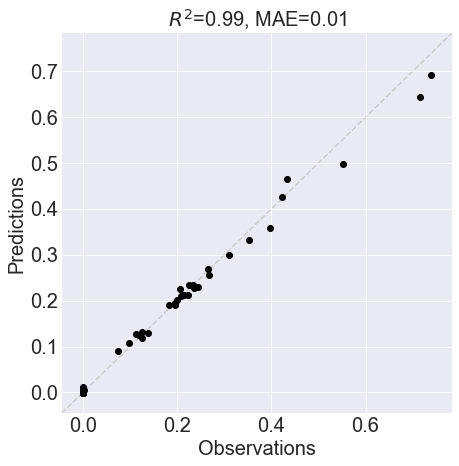

In [17]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, log=False)
# plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, xlim=[[0, 300]], ylim=[[0, 300]], log=False)

### Recommend new designs

Create the set of all possible designs:

In [45]:
num_of_designs = n_modifications**n_reactions
num_of_designs_onehot = art.num_input_var
strains = np.zeros((num_of_designs, num_of_designs_onehot))
num_of_designs

6561

In [46]:
i = 0
designs = np.eye(3)

for d1 in designs:
    for d2 in designs:
        for d3 in designs:
            for d4 in designs:
                for d5 in designs:
                    for d6 in designs:
                        for d7 in designs:
                            for d8 in designs:
                                strains[i,:] = np.hstack((d1,d2,d3,d4,d5,d6,d7,d8)).astype(int)
                                i+=1

Calculate mean predicted production and standard deviation for all possible designs.

In [48]:
pp_mean, pp_std = art.post_pred_stats(strains)


The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [50]:
art.rel_eng_accuracy = 0.01

#### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to $\alpha=0$).

In [52]:
obj_func = pp_mean 
data = np.hstack((strains, obj_func, obj_func))

In [53]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

,ACCOAC_0,ACCOAC_1,ACCOAC_2,MDH_0,MDH_1,MDH_2,PTAr_0,PTAr_1,PTAr_2,CS_0,...,PPC_0,PPC_1,PPC_2,PPCK_0,PPCK_1,PPCK_2,PFL_0,PFL_1,PFL_2,Isoprenol Concentration (mM)
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.679837
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.679658
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.678561
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.677532
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.676396
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.675863
6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.674870
7,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.674840
8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.674453
9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.673909


Mean and standard deviation of the recommendation with the highest predicted production are: 0.68, 0.08


Convert one-hot formatted variables back into categorical reactions positions

In [ ]:
df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['p1','p2','p3','p4','p5',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][art.recommendations.values[i,:] > 0]
    df_rec_categ_exploit.iloc[i]['p1':'p5'] = [int(float(p.split('_')[1])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]
df_rec_categ_exploit.head()

In [ ]:
df_rec_categ_exploit.nunique()

#### Explorative approach

In [ ]:
#Objective function is defined as the variance of the predicted production (the parameter for exploration is set to  𝛼=1 )

In [54]:
obj_func = pp_std 
data = np.hstack((strains, obj_func, obj_func))

In [55]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

,ACCOAC_0,ACCOAC_1,ACCOAC_2,MDH_0,MDH_1,MDH_2,PTAr_0,PTAr_1,PTAr_2,CS_0,...,PPC_0,PPC_1,PPC_2,PPCK_0,PPCK_1,PPCK_2,PFL_0,PFL_1,PFL_2,Isoprenol Concentration (mM)
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.648635
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.649677
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.649735
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.651283
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.652121
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.655291
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.632956
7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.659218
8,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.655731
9,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.657956


Mean and standard deviation of the recommendation with the highest predicted production are: 0.67, 0.08


In [ ]:
#Convert one-hot formatted variables back into categorical gene positions

In [ ]:
df_rec_categ_explor = pd.DataFrame(index=art.recommendations.index, columns=['p1','p2','p3','p4','p5',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][art.recommendations.values[i,:] > 0]
    df_rec_categ_explor.iloc[i]['p1':'p5'] = [int(float(p.split('_')[1])) for p in rec.index[:-1]]
    df_rec_categ_explor.iloc[i][measurement] = rec[measurement]
df_rec_categ_explor.head()

In [ ]:
df_rec_categ_explor.nunique()